In [166]:
import matplotlib.pyplot as plt


In [167]:
import utils
import importlib
importlib.reload(utils)

from utils import *

In [168]:
frame = (Point(0, 0), Point(10, 10))

In [169]:
p = get_random_point(frame)
c = get_random_courier(frame)
o = get_random_order(frame)
a = ActiveRoute(c, o)

In [170]:
couriers = [get_random_courier(frame) for _ in range(10)]
orders = [get_random_order(frame) for _ in range(10)]
acroutes = [ActiveRoute(c, o) for c, o in zip(couriers, orders)]

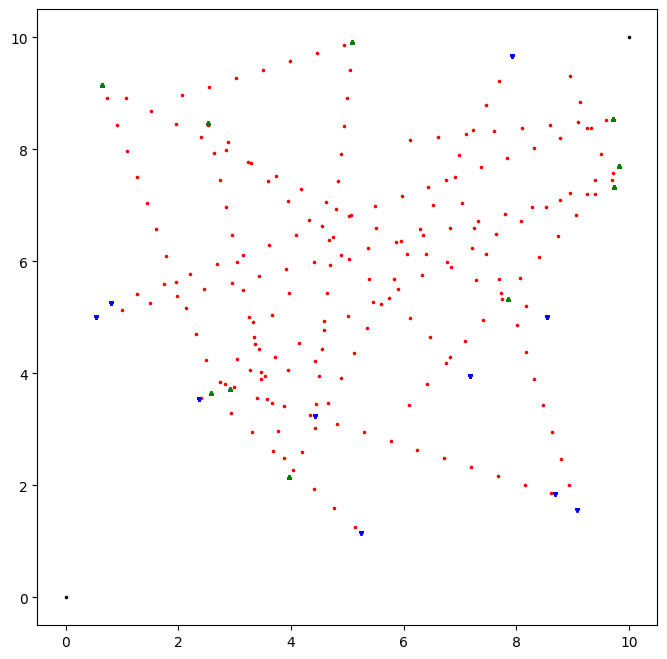

In [171]:
fig, ax = plt.subplots()
frame[0].plot(ax, color='black')
frame[1].plot(ax, color='black')
fig.set_figheight(8)
fig.set_figwidth(8)

for iter in range(100):
    for ar in acroutes:
        if ar.is_active:
            ar.plot(ax)
            ar.next(0.5)

<function utils.distance(first_point: utils.Point, second_point: utils.Point)>